# 기본과제 2 : Data augmentation for Quickdraw datset





기본과제 2번에서는 Quickdraw dataset에 대한 성능을 높이기 위한 다양한 image data augmentation을 사용해보게 됩니다. Data augmentation은 diverse한 image 생성을 통해 overfitting 방지하거나, 일종의 interpolation을 통한 data distribution 공간을 보다 dense하게 만드는 효과를 내 학습을 쉽게 하는 등의 효과가 있습니다. 이 과제에서는 무작위로 augmentation을 적용하는 것 보다, 학습 dataset 특성에 맞는 다양한 augmentation을 적용해보고 그 효과를 평가해보는 것이 목표입니다.

## Quickdraw dataset
아래 코드는 기본과제 1에서와 동일한 Quickdraw dataset의 준비 코드입니다. 다만, 이번 과제에서는 augmentation을 적용하기 위해 직접 transform을 정의하고, 해당 transformation을 torch.utils.data.Dataset class인 QuickDrawDataset에 직접 전달해주어야 하기 때문에, 해당 부분을 확인하실 수 있게 아래 코드로 독립시켜두었습니다.

In [1]:
#!pip3 install quickdraw

In [2]:
from quickdraw import QuickDrawData, QuickDrawDataGroup
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
import torch.nn as nn
#import albumentations
#import albumentations.pytorch
import pandas as pd

import random

In [3]:
num_img_per_class = 3000
qd = QuickDrawData(max_drawings=num_img_per_class)

In [4]:
seed = 111

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)

In [5]:
class_list = ['apple', 'wine bottle', 'spoon', 'rainbow', 'panda', 'hospital', 'scissors', 'toothpaste', 'baseball', 'hourglass']
class_dict = {'apple' : 0, 'wine bottle' : 1, 'spoon' : 2, 'rainbow' : 3, 'panda': 4, 'hospital' : 5, 'scissors' : 6, 'toothpaste' : 7, 'baseball' : 8, 'hourglass' : 9}

In [6]:
qd.load_drawings(class_list)

loading apple drawings
load complete
loading wine bottle drawings
load complete
loading spoon drawings
load complete
loading rainbow drawings
load complete
loading panda drawings
load complete
loading hospital drawings
load complete
loading scissors drawings
load complete
loading toothpaste drawings
load complete
loading baseball drawings
load complete
loading hourglass drawings
load complete


In [7]:
train_data = list()
val_data = list()
train_label = list()
val_label = list()
for class_name in class_list:
  qdgroup = QuickDrawDataGroup(class_name, max_drawings=num_img_per_class)
  for i, img in enumerate(qdgroup.drawings):
    if i < int(0.9 * num_img_per_class):
      train_data.append(img.get_image())
      train_label.append(class_dict[class_name])
    else:
      val_data.append(img.get_image())
      val_label.append(class_dict[class_name])

loading apple drawings
load complete
loading wine bottle drawings
load complete
loading spoon drawings
load complete
loading rainbow drawings
load complete
loading panda drawings
load complete
loading hospital drawings
load complete
loading scissors drawings
load complete
loading toothpaste drawings
load complete
loading baseball drawings
load complete
loading hourglass drawings
load complete


In [8]:
# Misc

class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
      self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

## Applying augmentations
이제 아래 정의된 ***class QuickDrawDatset(Dataset)***를 생성하는 과정에서 직접 정의한 augmentation을 적용할 수 있게 해야합니다. 캠퍼 여러분이 수행하야 하는 과제 내용은 아래와 같습니다.

- **TO DO (1-1)** : 다양한 패키지를 이용한 user-defined augmentation list를 적용해주세요. Image data augmentation을 위해 흔히 사용하는 패키지로는, *torchvision.transform*, *albumentation*, *imgaug*과 같은 패키지들이 있습니다. 다양한 패키지의 augmentation을 custom dataset에 직접 구현해보세요. 참고로, augmentation은 train dataset에만 적용하고 validation dataset에는 적용하지 않으시면 됩니다.

- **Hint** : 과제 1의 baseline 코드는 *torchvision.transform*를 이용해 주어진 이미지를 학습에 사용하기 위해 (224, 224) 크기로 resize하고, numpy.ndarray에서 tensor로 변환하고 있습니다. 원활한 학습을 위해서는 augmentation을 적용한 이후 **Resize(), ToTensor()**와 같은 함수를 이용해 적절한 형태로 이미지를 변환해주어야 합니다.

In [9]:
class QuickDrawDataset(Dataset):

    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        if self.transform:
          img = self.transform(img)
        return img, label

In [10]:
from torchvision.transforms.transforms import GaussianBlur
# TO DO (1-1) starts here
# Fill empty parts with proper code

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.GaussianBlur(kernel_size=(7, 13), sigma=(0.1, 0.2)),
    transforms.GaussianBlur(kernel_size=(7, 13)),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(degrees=(0, 10)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
# TO DO (1-1) ends here

In [12]:
qd_train_dataset = QuickDrawDataset(train_data, train_label, transform)
qd_val_dataset = QuickDrawDataset(val_data, val_label, transform_val)

qd_train_dataloader = DataLoader(qd_train_dataset, batch_size=64, shuffle=True)
qd_val_dataloader = DataLoader(qd_val_dataset, batch_size=64, shuffle=True)

## Visualizing augmentated images
다양한 augmentation을 적용한 이후에는, 원하는 augmentation이 잘 적용되고 있는지 확인해보는 과정이 필수적입니다. Augmentation 뿐만 아니라, Computer Vision의 다양한 모델들을 구현할 때는 모델의 input, output image나 중간 feature map을 시각화해보는 것이 아주 중요합니다. 이를 통해, 사소한 실수를 방지할 수 있을 뿐 아니라, loss로는 파악하기 힘든 모델의 성능 및 강점/약점을 파악할 수 있기 때문입니다.

따라서, 이번에는 augmentation이 잘 적용되었는지 확인해보는 코드를 작성해야 합니다. 

- **TO DO (2-1)** : 직접 정의한 augmentation을 사용하느 qd_train_dataloader와 augmentation을 사용하지 않는 qd_val_dataloader의 이미지들을 직접 확인할 수 있는 코드를 작성해주세요.
- **Hint 1** : *iter(), next()* 함수를 이용하면 dataloader에서 image 및 label을 반복적으로 추출할 수 있습니다. 
- **Hint 2** : 이미지의 channel order를 고려해야 합니다. cv2의 경우는 default channel order가 BGR인데 반해, PyTorch에서는 일반적으로 RGB order로 학습을 진행하는 경우가 많습니다. Quickdraw dataset의 경우 흑백 이미지라서 차이를 고려하지 않아도 괜찮지만, 컬러 이미지의 경우 이러한 차이가 큰 문제로 이어질 수 있습니다. 가령, RGB 이미지로 학습을 진행하고 *cv2.imread()*로 이미지를 불러와 그대로 model에 넣어주는 경우 모델이 아주 낮은 성능을 기록할 수 있습니다.
- **Hint 3** : 각 dimension이 무엇을 나타내는지도 고려해야 합니다. cv2는 (height, width, channel) 순서로 이미지를 처리하지만, torch의 *conv2d* layer의 경우 (batch, channel, height, width) 순서의 tensor를 입력받습니다. 따라서, *permute()* 같은 함수를 통해 channel 순서를 바꿔주거나, *torch.squeeze(), torch.unsqueeze(), np.newaxis()*등을 dummy batch dimension을 생성/제거해주는 경우도 많이 있습니다.
- **Hint 4** : 아직 이미지를 GPU에 올리지 않아 해당되지 않는 사항이지만, GPU에 올라간 이미지는 바로 *.cpu()*와 같은 함수를 통해 cpu에 올린 이후 ndarray로 변환해야 하는 경우도 있습니다. 또, gradient가 계산되는 경우는 *.detach()*와 같은 함수를 사용해야 할 수도 있습니다.

이미지를 확인해보기 위해 위 힌트들이 모두 필요할 수도, 아닐 수도 있습니다. 본인이 augmentation을 구현한 방법을 잘 고려해서 본인의 방식대로 이미지를 확인해보면 됩니다. 다만, 위 힌트들은 일반적으로 확인해야 하는 경우가 많기 때문에 관련 내용을 확인해보시는 것을 추천드립니다.

In [13]:
# TO DO (2-1) starts here
# Fill empty parts with proper code
img, label = next(iter(qd_train_dataloader))
#img, label = next(iter(qd_val_dataloader))

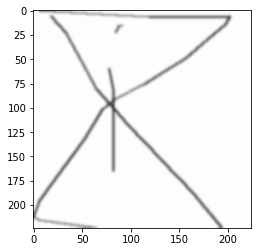

In [14]:
import matplotlib.pyplot as plt

visualized_img = img[0].numpy().transpose((1, 2, 0))
visualized_img = visualized_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
visualized_img = np.clip(visualized_img, 0, 1)

# TO DO (2-1) ends here
plt.imshow(visualized_img)
plt.show()

## Training VGG-11 with augmented images
이제 augmentation을 적용한 이미지들을 이용해 VGG-11 model을 다시 학습해봅니다. Augmetation을 적용한 경우와 그렇지 않은 경우, 학습이 어떻게 진행되는지 확인해보세요. 단순히 augmentation을 이것저것 적용해보면서 그 중 loss가 가장 낮게 나온 것을 고르는 것 보다는 결과가 좋아졌다면 왜 좋아졌는지, 나빠졌다면 왜 나빠졌는지 나름의 이유를 고민해보시는 것이 중요합니다. 또, 필요한 경우에 loss 그래프만 보는 것 대신 위에서 해본 것 처럼 model의 output을 직접 확인해보면서, 어떤 경우에 model이 더 좋아지거나 나빠졌는지 확인해보세요.

In [15]:
from torchvision.models import vgg11

pretrained = True # True of False

model = vgg11(pretrained)
model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
model.cuda()

# Freeze the feature extracting convolution layers

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [16]:
log_dir ='./log'

In [17]:
# Loss function and Optimizer
from torch.optim import Adam

criterion = nn.CrossEntropyLoss()
optimizer_ft = Adam(model.parameters(), lr=1e-4)

In [18]:
# Main
os.makedirs(log_dir, exist_ok=True)

with open(os.path.join(log_dir, 'augmentation_train_log.csv'), 'w') as log:
  # Training
  model.train()
  for iteration, (img, label) in enumerate(qd_train_dataloader):
    # optimizer에 저장된 미분값을 0으로 초기화
    optimizer_ft.zero_grad()

    # GPU 연산을 위해 이미지와 정답 tensor를 GPU로 보내기 (필요한 경우, 변수의 type도 수정해주세요)
    img, label = img.float().cuda(), label.long().cuda()
  
    # 모델에 이미지 forward
    pred_logit = model(img)

    # loss 값 계산
    loss = criterion(pred_logit, label)

    # Backpropagation
    loss.backward()
    optimizer_ft.step()

    # Accuracy 계산
    pred_label = torch.argmax(pred_logit, 1)
    acc = (pred_label == label).sum().item() / len(img)

    train_loss = loss.item()
    train_acc = acc

    # Validation for every 20 epoch
    if (iteration % 20 == 0) or (iteration == len(qd_train_dataloader)-1):
      model.eval()
      valid_loss, valid_acc = AverageMeter(), AverageMeter()

      for img, label in qd_val_dataloader:
        # GPU 연산을 위해 이미지와 정답 tensor를 GPU로 보내기 (필요한 경우, 변수의 type도 수정해주세요)
        img, label = img.float().cuda(), label.long().cuda()

        # 모델에 이미지 forward (gradient 계산 X)
        with torch.no_grad():
          pred_logit = model(img)

        # loss 값 계산
        loss = criterion(pred_logit, label)

        # Accuracy 계산
        pred_label = torch.argmax(pred_logit, 1)
        acc = (pred_label == label).sum().item() / len(img)
        valid_loss.update(loss.item(), len(img))
        valid_acc.update(acc, len(img))

      valid_loss = valid_loss.avg
      valid_acc = valid_acc.avg

      print("Iter [%3d/%3d] | Train Loss %.4f | Train Acc %.4f | Valid Loss %.4f | Valid Acc %.4f" %
            (iteration, len(qd_train_dataloader), train_loss, train_acc, valid_loss, valid_acc))
      
      # Train Log Writing
      log.write('%d,%.4f,%.4f,%.4f,%.4f\n'%(iteration, train_loss, train_acc, valid_loss, valid_acc))

Iter [  0/422] | Train Loss 2.2922 | Train Acc 0.1719 | Valid Loss 2.2286 | Valid Acc 0.2253
Iter [ 20/422] | Train Loss 0.3166 | Train Acc 0.9219 | Valid Loss 0.4698 | Valid Acc 0.8700
Iter [ 40/422] | Train Loss 0.3528 | Train Acc 0.8594 | Valid Loss 0.3461 | Valid Acc 0.9027
Iter [ 60/422] | Train Loss 0.1618 | Train Acc 0.9531 | Valid Loss 0.3430 | Valid Acc 0.9057
Iter [ 80/422] | Train Loss 0.3137 | Train Acc 0.8594 | Valid Loss 0.3659 | Valid Acc 0.8963
Iter [100/422] | Train Loss 0.3018 | Train Acc 0.9219 | Valid Loss 0.2970 | Valid Acc 0.9160
Iter [120/422] | Train Loss 0.1292 | Train Acc 0.9688 | Valid Loss 0.2334 | Valid Acc 0.9320
Iter [140/422] | Train Loss 0.0620 | Train Acc 1.0000 | Valid Loss 0.2519 | Valid Acc 0.9273
Iter [160/422] | Train Loss 0.3151 | Train Acc 0.9062 | Valid Loss 0.2572 | Valid Acc 0.9210
Iter [180/422] | Train Loss 0.3125 | Train Acc 0.8750 | Valid Loss 0.2517 | Valid Acc 0.9277
Iter [200/422] | Train Loss 0.1488 | Train Acc 0.9219 | Valid Loss 0.2

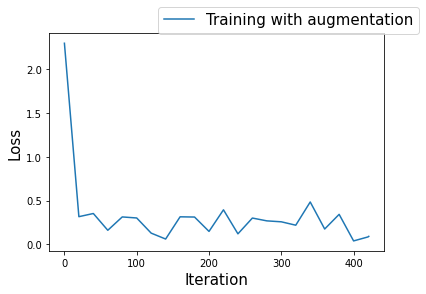

In [19]:
# Visualize training log
augmentation_train_log = pd.read_csv(os.path.join(log_dir, 'augmentation_train_log.csv'), index_col=0, header=None)
fig, ax = plt.subplots()
ax.plot(augmentation_train_log.iloc[:,0], label='Training with augmentation')
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)

fig.legend(fontsize=15)

plt.show()

## Some other methods to improve model performance
Augmentation을 적용한 모델의 결과가 더 좋아졌나요? 성능이 향상되었다면 축하드리며, 성능이 좋아지지 않거나 오히려 나빠졌더라도 괜찮습니다. 중요한 것은 augmentation으로 이 과제 코드에서 성능을 얼마나 올렸는지가 아니라, 다음에 다른 dataset, 다른 model로 학습을 진행할 때 필요한 augmentation을 생각해낼 수 있는 나름의 성공/실패 경험과 이유를 만드는 것이기 때문입니다.

데이터의 특성 및 모델의 특성을 반영할 수 있는 몇가지 추가 질문들입니다. 아래 질문들에 대해 나름의 답을 생각해보시고, 직접 실험해보면서 다음에 새로운 데이터셋과 모델을 만난다면 어떤 augmentation을 왜 적용해야 할지, 나름대로의 이유를 생각해보시고, 실험해보시고, 다른 캠퍼분들과 토의해보세요.

1. Quickdraw dataset은 상당히 얇은 선의 이미지들로 이루어졌습니다. 이런 경우, blur augmentation을 적용해 이미지를 넓게 만들어주는 것이 성능 향상에 도움이 될 수 있습니다. 왜 blur augmentation이 모델 성능 향상에 도움이 되는지 생각해보세요. Hint) 이미지가 얇은 선으로 이루어져 있다는 것은 빈 공간이 많다는 뜻이고, 이는 곧 layer의 input으로 0이 상당히 많이 들어간다는 뜻입니다.

2. Augmentation의 효과를 더욱 크게 하기 위해서는, 구현의 편의를 위해 (224, 224)로 image를 resize하는 대신 훨씬 작은 원본 이미지 크기를 사용하는 것이 좋을 수 있습니다. 위 blur augmentation이 (224,224)에서 효과가 적은 이유에 대해서 고민해보세요. Hint) CNN의 convolution filter 의 사이즈와 연관이 있습니다.

3. Augmentation의 순서 역시 중요한 요소가 될 수 있습니다. Blur를 먼저 적용하고 크게 resize하는 경우와 resize를 먼저 하고 blur를 적용하는 경우, 이미지가 어떻게 달라질지 예상해보시고, 실제 augmentation package에 따라 결과가 어떻게 나타나는지도 확인해보세요. 그리고 Geometric augmentation의 경우에 대해서도 순서가 어떻게 영향을 미칠지 생각해보세요. 

4. Augmentation을 적용했음에도, convolution layers를 고정하고 linear classifier만 새로 학습하는 fine-tuning을 수행하면 augmentation의 효과가 떨어질 수 있습니다. 그 이유에 대해 생각해보세요.

**TO DO (3-1)** : 위 further question에 대해 고민해보고, 직접 실험해보며 결과를 확인해보세요. 